In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt

%matplotlib inline 


import random

In [2]:
class RBF_Net(object):
    def __init__(self):
        return 
        
    def fit(self, X_train, Y_train, C):
        self.X = X_train
        self.Y = Y_train.T
        self.C = C
        
        self.d = self.d_constr(self.C)
        self.F = self.F_constr(self.X, self.C, self.d)
        #self.F = self.F_mah_constr(self.X, self.C, self.d)
        self.Wb = self.train(self.Y, self.F)
        
        self.y_dim = len(Y_train[0])
        self.x_dim = len(X_train[0])

    def d_constr(self, C):
        N = len(C)
        d = np.zeros(N)
        l = np.zeros(N)
        
        for i in tqdm(range(N),"Distant progress"):
            for j in range(N):
                l[j] = np.linalg.norm(C[i] - C[j])
            d[i] = np.std(l) 
        return d

    def F_constr(self, X, C, d):
        S = len(X)
        N = len(C)
        
        F = np.zeros((N, S))
        for i in tqdm(range(N),"F progress"):
            for j in range(S):
                F[i][j] = np.linalg.norm(X[j] - C[i])
            F[i] = F[i] / d[i]
        F = np.exp(-(F ** 2))
        return F
    
    def F_mah_constr(self, X, C, d):
        S = len(X)
        N = len(C)
        F = np.zeros((N, S))
        Z = np.cov(X.T)
        
        Z = tf.linalg.pinv(Z, rcond = 10**(-100), validate_args = True)
        
        Z = tf.make_tensor_proto(Z)
        Z = tf.make_ndarray(Z)
        
        for i in tqdm(range(N),"F progress"):
            for j in range(S):
                v = np.reshape(X[j] - C[i],(1,-1))
                vv = np.dot(v, Z)
                F[i][j] = np.dot(vv, v.T)
        return F
        
    def FA_const(self, F):
        a = np.ones((1, len(F[0])))
        return np.vstack((F, a))
        
    def train(self, Y, F):
        FA = self.FA_const(F)
        
        FAFAT =tf.linalg.matmul(FA, FA, transpose_b=True)

        self.mu = np.linalg.cond(tf.make_ndarray(tf.make_tensor_proto(FAFAT)))
        FAFAT = tf.linalg.pinv(FAFAT, rcond = 10**(-100), validate_args = True)
        
        Wb =  tf.linalg.matmul(Y, FA, transpose_b=True)
        Wb =  tf.linalg.matmul(Wb, FAFAT)

        #YY = tf.linalg.matmul(Wb, FA)
        
        Wb = tf.make_tensor_proto(Wb)
        Wb = tf.make_ndarray(Wb)
        
        print('Train complete')
        
        return Wb
        
        
        
    def predict(self, X):
        F = self.F_constr(X, self.C, self.d)
        FA = self.FA_const(F)
        Y_pr = np.dot(self.Wb, FA)
        return Y_pr.T       
    pass

In [3]:
def weighting(X, func_type):

    if func_type == 'sin':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)
        return X*weight

    if func_type == 'sin^2':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)**2
        return X*weight

    if func_type == 'sin^4':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)**4
        return X*weight

    if func_type == '1-log':
        return 1 - (X[:,0:1] ** 2 + X ** 2) / 10

    if func_type == 'log':
        return np.log(X)

    if func_type == 'm_func':
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.copy(angles)
        for i in range(len(angles)):
            if i == 0:
                weight[i] = 0
            if (i > 0) and (i < 90):
                weight[i] = (np.exp(-2*(np.log(i/54.0))**2))/i
            
            if (i > 90):
                weight[i] = weight[181-i]

        return X * weight

def cutter(X, start, end):
    return X[:,start:end+1]

In [4]:
def predict_plot(y_test, y_pred, params):
    N = len(params)
    
    plt.figure(figsize=(20,20))
    
    for i in range (N):
        for j in range(N):
            plt.subplot(N, N, i*N+j+1)

            plt.title("Предсказание с помощью сетей")
            plt.xlabel(params[i])
            plt.ylabel(params[j])

            plt.plot(y_test[:,i], y_test[:,j] ,'*', label = "Тест")
            plt.plot(y_pred[:,i], y_pred[:,j], '.', label = "Предсказание")
            plt.legend()


def error_plot(y_test, y_pred, params):
    
    N = len(params)
    
    error = []
    for j in range(len(y_pred[0])):
        buf_err = []    
        for i in range(len(y_pred)):
            buf_err.append((y_test[i,j]-y_pred[i,j]))   
        error.append(buf_err)


    plt.figure(figsize=(20,20))
    
    for i in range (N):
        
        plt.subplot(N, 2, i*2+1)
        plt.title("Ошибка предсказания %s" %(params[i]))
        plt.ylabel("Ошибка предсказания %s" %(params[i]))
        plt.xlabel("Номер индикатрисы")
        plt.plot(error[i],'*')
        
    
        plt.subplot(N, 2, i*2+2)
        plt.title("Распределение ошибки %s" %(params[i]))
        plt.xlabel("Ошибка предсказания %s" %(params[i]))
        plt.hist(error[i], 100)
        plt.text(0,0,'mu = %f \n sigma = %f' %(np.mean(error[i]),np.std(error[i])),bbox=dict(facecolor='white'))

    return error

In [5]:
col_list = ['r', 'x' ,'n', 'tetha']
for i in range(181):
    col_list.append(str(i))

df = pd.read_csv('Plt_200k_h2.csv', delimiter = ';', names = col_list)
#print(df[df['r'] == 0].index)
df = df.drop(df[df['r'] == 0].index)
df = df.reset_index(drop=True)

In [6]:
xx = (np.array(df)[:,4:])
yy = np.array(df)[:, :4]
xx = weighting(xx, 'm_func')
xx = cutter(xx, 10 , 70)

In [7]:
x_train,x_test,y_train,y_test= train_test_split(xx, yy, test_size=0.01, shuffle=True)

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2000, random_state=0, max_iter = 40, verbose = True)
print(kmeans.fit(xx))
C = kmeans.cluster_centers_

Initialization complete
Iteration 0, inertia 12631.075648963713
Iteration 1, inertia 10596.532079084996
Iteration 2, inertia 10269.435032968999
Iteration 3, inertia 10129.980004201967
Iteration 4, inertia 10050.283556112421
Iteration 5, inertia 10000.779556351672
Iteration 6, inertia 9966.283100506927
Iteration 7, inertia 9942.55799748818
Iteration 8, inertia 9926.55012293618
Iteration 9, inertia 9914.46759309231
Iteration 10, inertia 9904.444195006183
Iteration 11, inertia 9896.665683917823
Iteration 12, inertia 9890.387074756012
Iteration 13, inertia 9883.903425219582
Iteration 14, inertia 9879.522221625895
Iteration 15, inertia 9875.70737941235
Iteration 16, inertia 9872.230700950526
Iteration 17, inertia 9869.08237463726
Iteration 18, inertia 9866.155880773164
Iteration 19, inertia 9863.414399170486
Iteration 20, inertia 9861.085549777781
Iteration 21, inertia 9858.789291525318
Iteration 22, inertia 9856.485631869724
Iteration 23, inertia 9854.190087086994
Iteration 24, inertia 985

Iteration 3, inertia 10126.673061610292
Iteration 4, inertia 10045.136005697683
Iteration 5, inertia 9997.543178630032
Iteration 6, inertia 9962.620219678282
Iteration 7, inertia 9936.919236975855
Iteration 8, inertia 9918.705245081397
Iteration 9, inertia 9904.8581046648
Iteration 10, inertia 9892.957627924961
Iteration 11, inertia 9882.694627601217
Iteration 12, inertia 9873.6448760029
Iteration 13, inertia 9866.09236502894
Iteration 14, inertia 9859.809888788606
Iteration 15, inertia 9854.374294417927
Iteration 16, inertia 9850.394967617633
Iteration 17, inertia 9847.211147135751
Iteration 18, inertia 9844.459238889005
Iteration 19, inertia 9842.273182758538
Iteration 20, inertia 9840.459073142847
Iteration 21, inertia 9838.573205220464
Iteration 22, inertia 9836.767320848561
Iteration 23, inertia 9835.222144908412
Iteration 24, inertia 9834.017902553624
Iteration 25, inertia 9832.907160571483
Iteration 26, inertia 9831.684150022991
Iteration 27, inertia 9830.200283340751
Iteration 

In [10]:
rbf = RBF_Net()
rbf.fit(x_train, y_train, C)
y_pred = rbf.predict(x_test)

F progress: 100%|██████████████████████████| 2000/2000 [47:48<00:00,  1.43s/it]


Train complete


F progress: 100%|██████████████████████████| 2000/2000 [00:31<00:00, 63.99it/s]


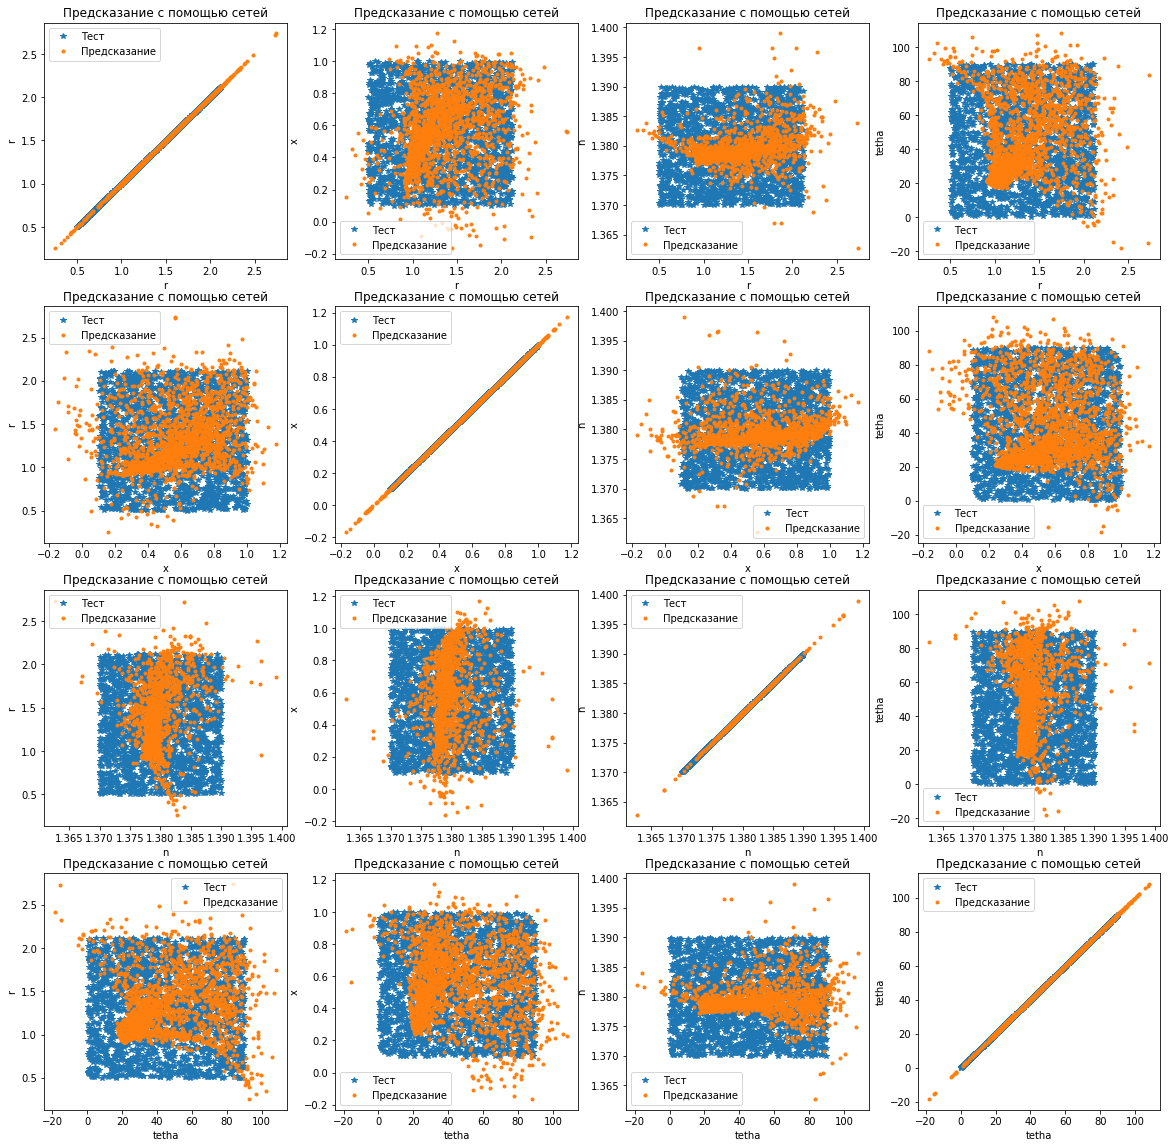

In [18]:
predict_plot(y_test, y_pred, ['r', 'x' ,'n', 'tetha'])

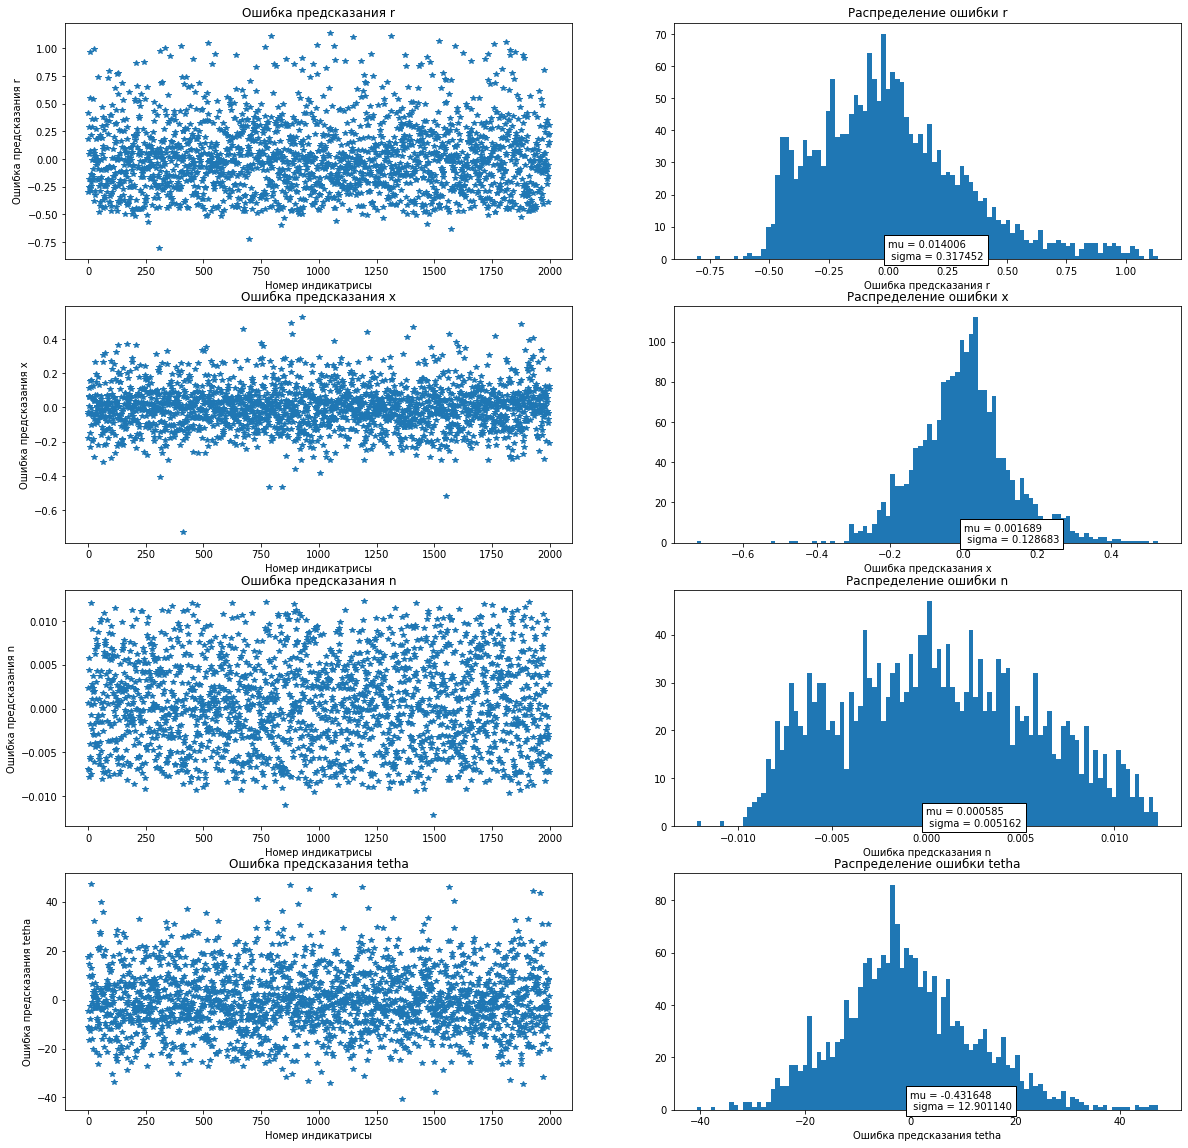

In [19]:
errors = error_plot(y_test, y_pred,['r', 'x' ,'n', 'tetha'])

In [13]:
x_test_noise = np.copy(x_test)
for i in range(len(x_test_noise)):
    sigma = np.max((x_test_noise[i])) * 0.03
    for j in range(len(x_test_noise[i])):
        x_test_noise[i][j] = np.random.normal(x_test_noise[i][j], sigma)

In [14]:
y_pred_noise = rbf.predict(x_test_noise)

F progress: 100%|██████████████████████████| 2000/2000 [00:30<00:00, 65.54it/s]


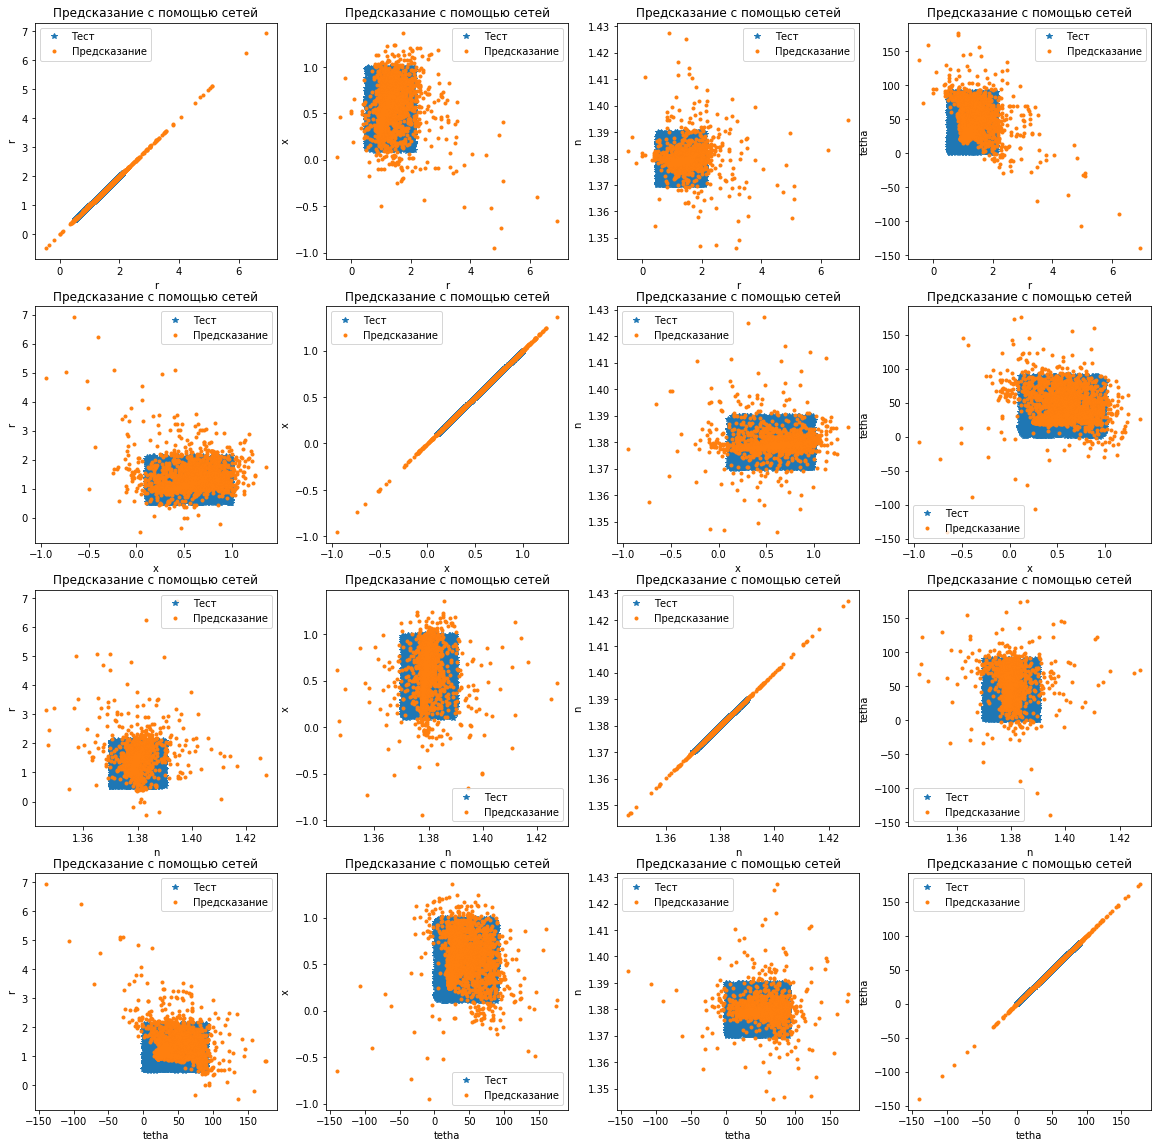

In [20]:
predict_plot(y_test, y_pred_noise, ['r', 'x' ,'n', 'tetha'])

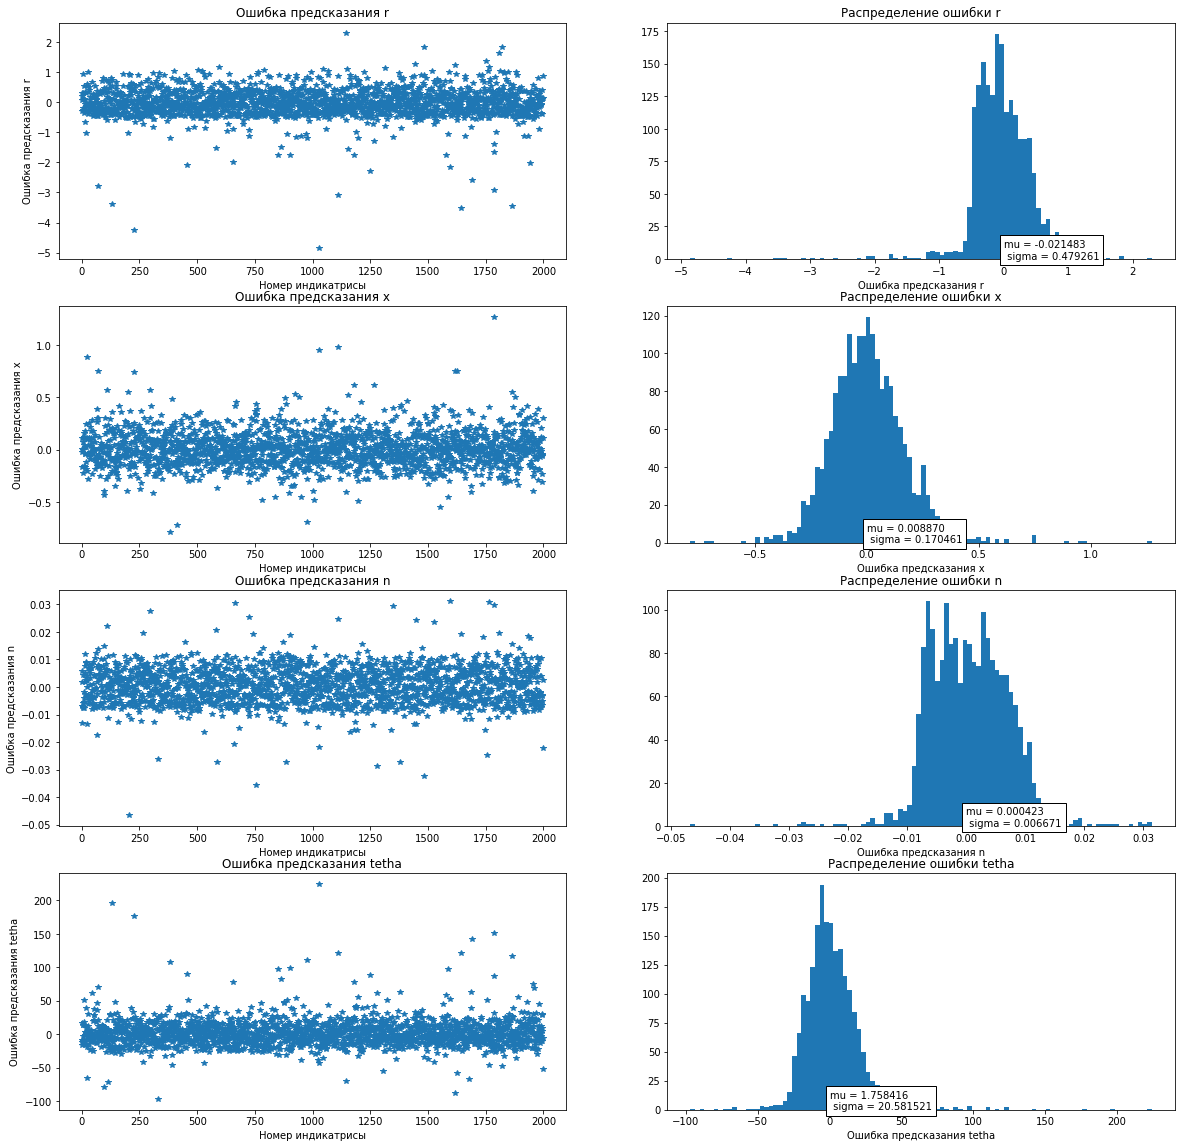

In [21]:
errors = error_plot(y_test, y_pred_noise,['r', 'x' ,'n', 'tetha'])

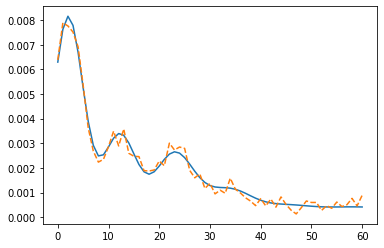

In [22]:
plt.plot(x_test[1],'-',x_test_noise[1],'--')

In [32]:
del rbf